In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys, os, time
import scipy.stats
import pickle
import scipy

# Reionization module
sys.path.append('reionization/')
import reionization

# Dynesty imports
from multiprocessing import Pool
import dynesty
from dynesty import plotting as dyplot
from dynesty import DynamicNestedSampler
from dynesty import utils as dyfunc
import ipyparallel as ipp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

np.seterr(divide='ignore')

%timeit
%lprun

%matplotlib inline
mpl.rcParams['font.size'] = 16

# To use multiprocessing run following command:
# > ipcluster start -n 7
rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)
dview = rc[:]
dview.use_dill();

[0, 1, 2, 3, 4, 5, 6]


# Nion inference

This notebook creates the Nion posteriors described in [Mason et al. 2019](https://ui.adsabs.harvard.edu/abs/2019arXiv190711332M/abstract)

# Plot labels

In [2]:
label_z    = 'Redshift, z'
label_rhoL = r'$\log_{10}(\rho_L \, [$erg s$^{-1}$ Hz$^{-1}$ Mpc$^{-3}])$'
label_Nion = r'$\log_{10}(\dot{N}_\mathrm{ion} \, [$s$^{-1}$ Mpc$^{-3}])$'
label_xHII = r'IGM ionized fraction, $\overline{x}_\mathrm{HII}$'
label_xHI  = r'IGM neutral fraction, $\overline{x}_\mathrm{HI}$'
label_tau  = r'CMB optical depth, $\tau_e$'

# Setup to run inference

Define the redshift grid to work on (= number of parameters).

Note that smaller redshift bins are not advised as you get a lot of fluctuations.

In [4]:
ztab = np.arange(4.,15., 1.)
print(ztab)
zlabels = [r'$\dot{N}_\mathrm{ion}(z=%.1f)$' % z for z in ztab]

ndim = len(ztab)
print(ndim)

# Reionization object
reion = reionization.ReionizationTimeline(ztab=ztab)

# Inference object
infer = reionization.NionInference(reion, ztab)

[ 4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
11
Using Planck15 cosmology


# Run inference using Dynesty in parallel

Dynesty is dynamic nested sampling. For more info see [https://dynesty.readthedocs.io](https://dynesty.readthedocs.io/en/latest/) and [Speagal (2019)](https://arxiv.org/abs/1904.02180)

## Loading and plotting functions

In [11]:
def dyn_plots(results, corner=True):
    # Plot a summary of the run.
    rfig, raxes = dyplot.runplot(results, span=[0.0, (0., 1.1), 0.0, (0., 1.05*np.exp(np.nanmax(results.logz)))])

    # Plot traces and 1-D marginalized posteriors.
    tfig, taxes = dyplot.traceplot(results)

    # Plot the 2-D marginalized posteriors.
    if corner:
        cfig, caxes = dyplot.cornerplot(results)
    
    return

def load_samples(chain_file, save=False):
    res = pickle.load(open(chain_file, 'rb'))
    
    samples = res.samples  # samples
    weights = np.exp(res.logwt - res.logz[-1])  # normalized weights
    samples = dyfunc.resample_equal(samples, weights) # Resample weighted samples.
    
    if save:
        np.save(chain_file.replace('.pickle','_samples'), samples)
        
    return samples

def confidence_interval(samples, percentile=68., axis=0):
    """
    Calculate median and confidence levels for samples
    """
    
    plow  = 50. - percentile/2.
    phigh = 50. + percentile/2.
    
    med  = np.median(samples, axis=axis)
    low  = np.percentile(samples, plow, axis=axis)
    high = np.percentile(samples, phigh, axis=axis)
    
    return med, low, high

def plot_samples(samples, ztab, Nsample=500, c='tab:orange', zorder=0, drawstyle='default'):
    for nion in samples[np.random.randint(len(samples), size=Nsample)]:
        plt.plot(ztab, nion, alpha=0.05, c=c, zorder=zorder,  drawstyle=drawstyle)
    return

## Using only dark fraction and Planck

In [17]:
# Inference object
infer = reionization.NionInference(reion, ztab)

chain_file_2obs = "chains/res_2obs_U[-1,1]_49-53_pool.pickle"

maxiter = 20000
if __name__ == '__main__':
   
    # sample from the target distribution
    t0 = time.time()
    npool = 7
    with ProcessPoolExecutor(max_workers=npool) as executor:
        
        sampler = DynamicNestedSampler(
                                infer.lnlike, infer.prior_transform, infer.ndim, 
                                sample='rwalk', pool=executor, 
                                queue_size=npool)
        
        sampler.run_nested(dlogz_init=0.1, nlive_init=500, maxiter=maxiter, use_stop=False, wt_kwargs={'pfrac': 1.0})
        
        res = sampler.results
        
        pickle.dump(res, open(chain_file_2obs,"wb"))

    t_run = (time.time()-t0)/60.
    print("Took {0:.10f} mins".format(t_run))

iter: 1831 | batch: 0 | bound: 0 | nc: 36 | ncall: 17826 | eff(%):  9.991 | loglstar:   -inf <  8.653 <    inf | logz:  4.908 +/-  0.079 | dlogz:  0.868 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 1837 | batch: 0 | bound: 1 | nc: 70 | ncall: 18266 | eff(%):  9.789 | loglstar:   -inf <  8.660 <    inf | logz:  4.921 +/-  0.078 | dlogz:  0.854 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number 

Took 25.1435064713 mins


In [18]:
# Save samples
samples = load_samples(chain_file_2obs, save=True)

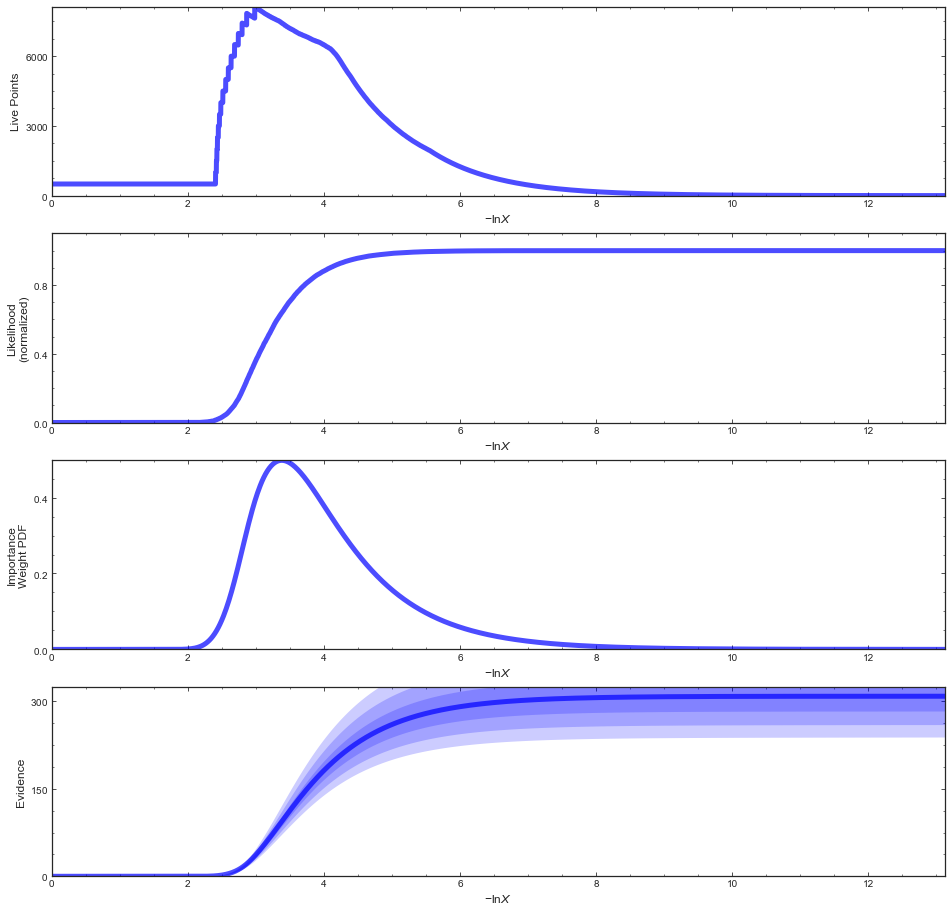

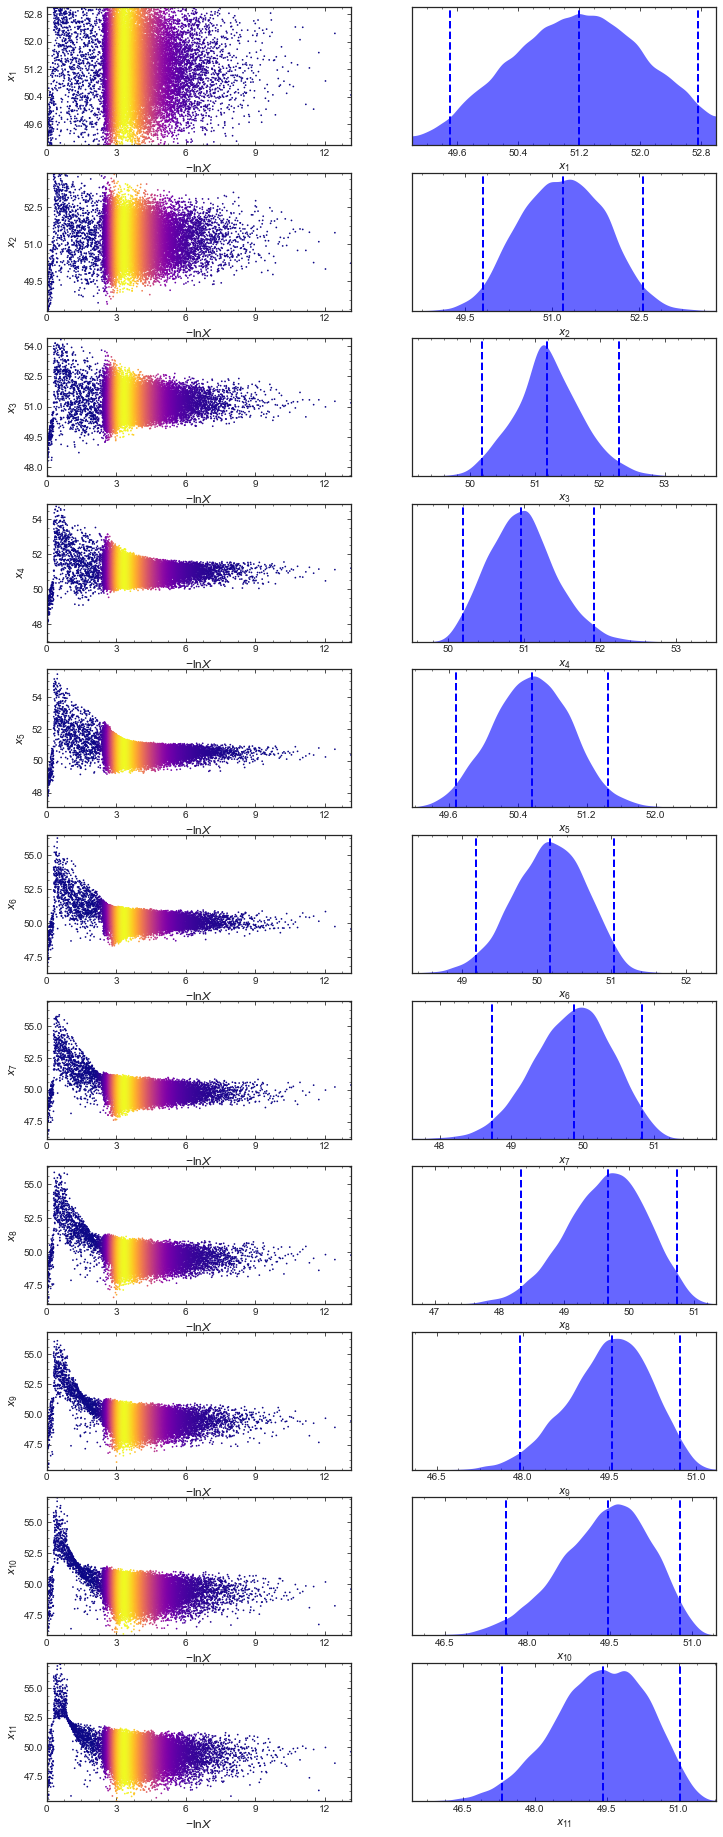

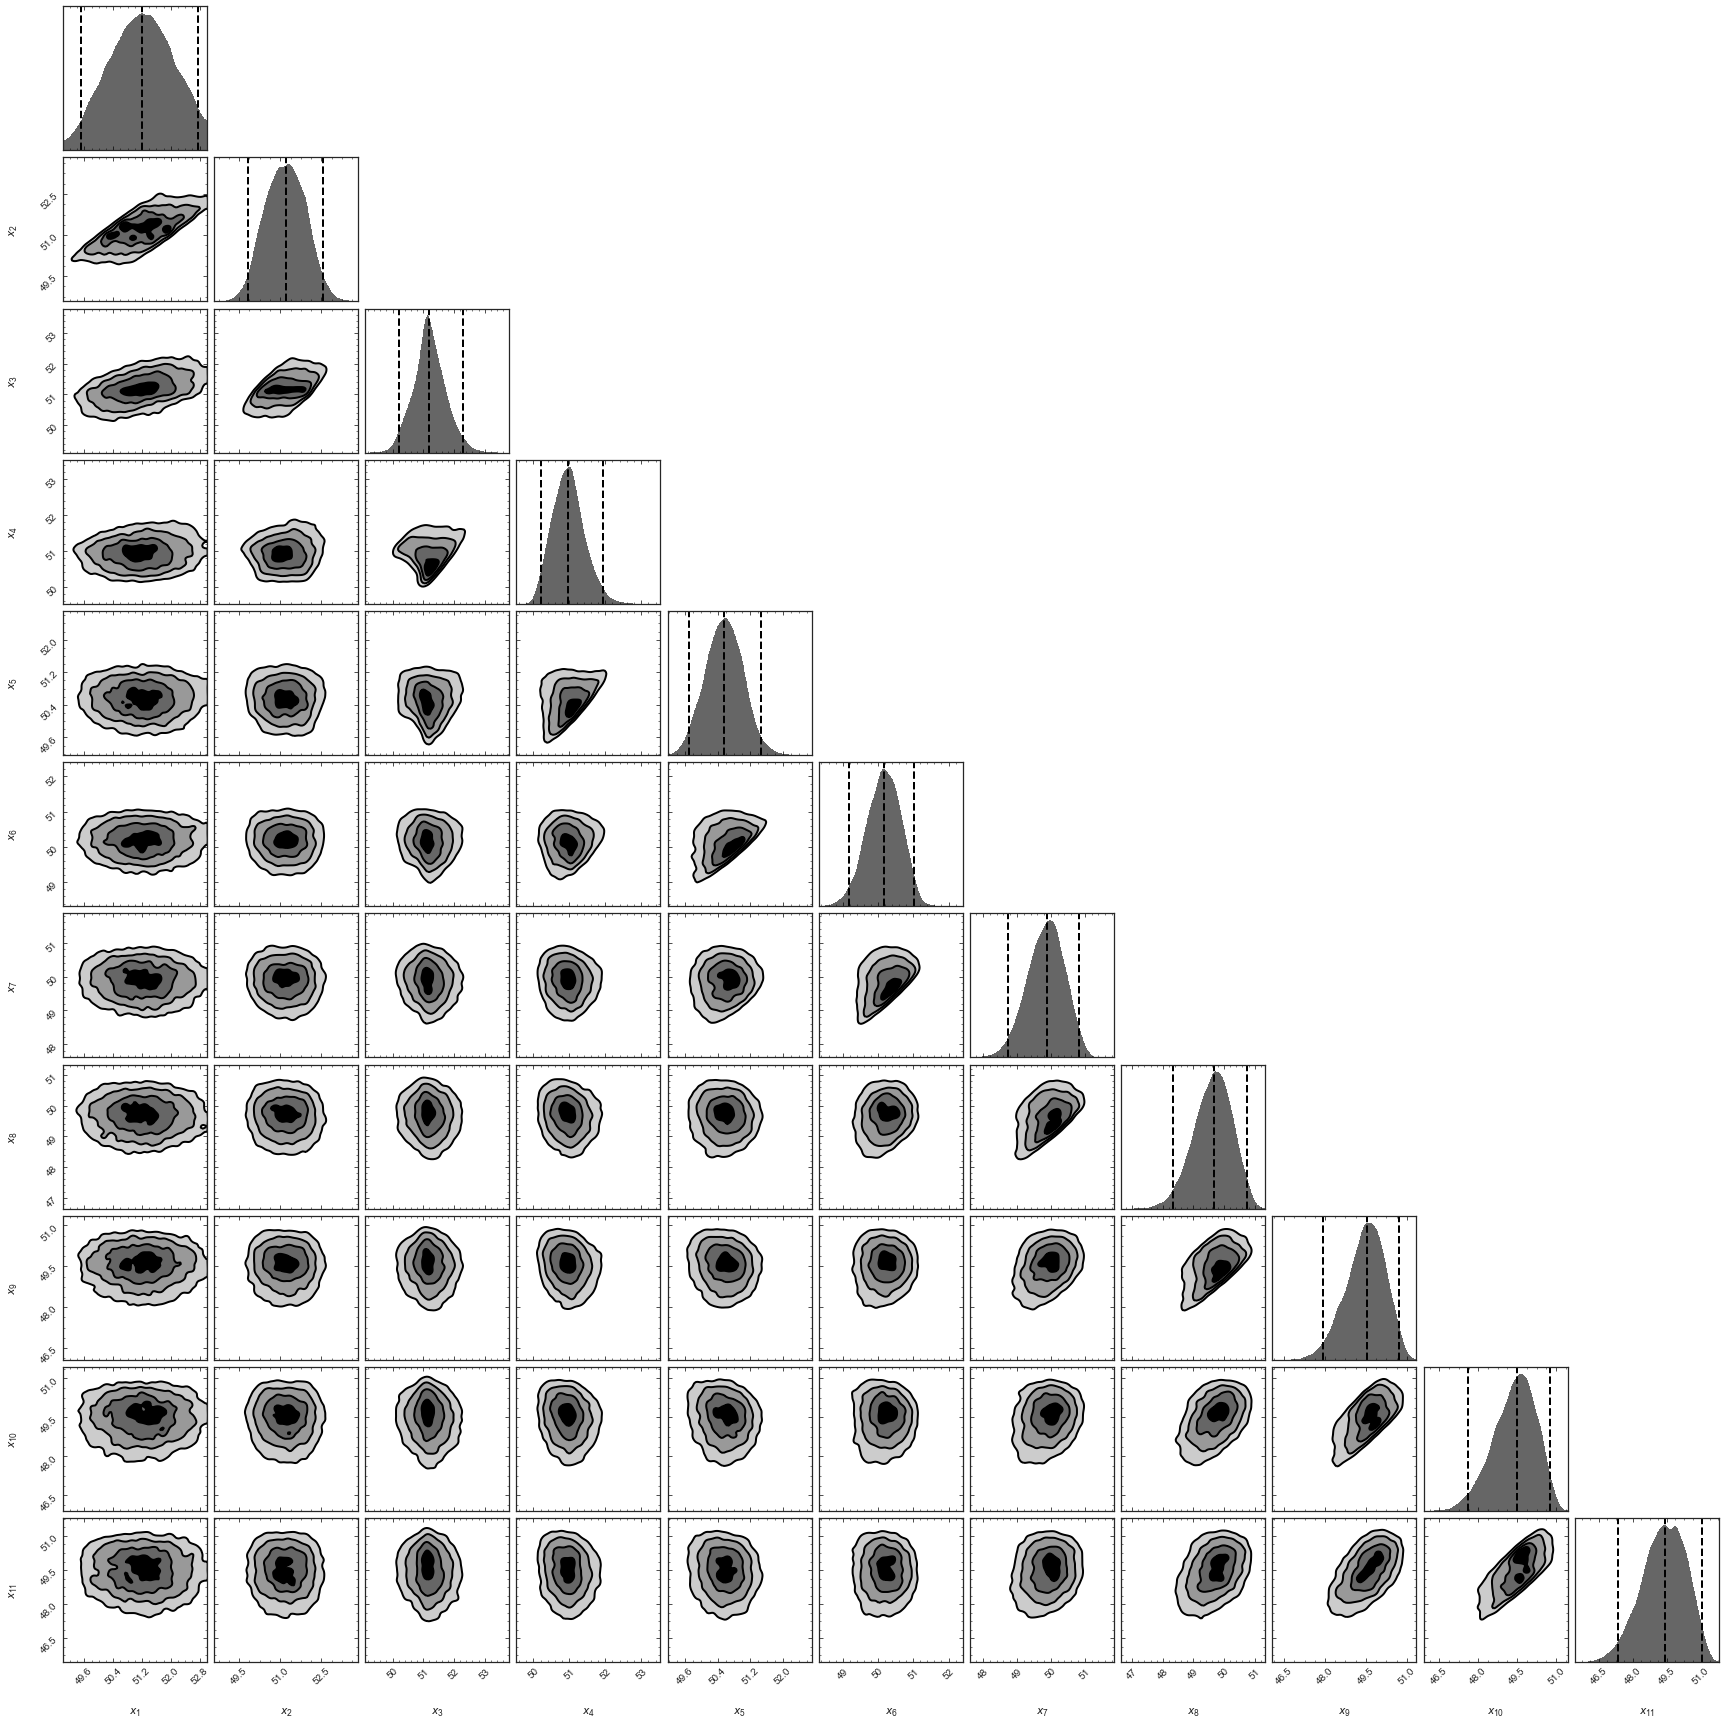

In [19]:
# Plot
dyn_plots(res)

## All constraints

Including Lya damping constraints from:

- [Mason+19a](https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.3947M/abstract)
- [Hoag+19](https://ui.adsabs.harvard.edu/abs/2019ApJ...878...12H/abstract)
- [Greig+19](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.5094G/abstract)
- [Mason+18a](https://ui.adsabs.harvard.edu/abs/2018ApJ...856....2M/abstract)
- [Davies+18](https://ui.adsabs.harvard.edu/abs/2018ApJ...864..142D/abstract)

In [40]:
# Inference object
infer_allobs = reionization.NionInference(reion, ztab, allconstraints=True)

chain_file_allobs = "chains/res_allobs_G19_U[-1,1]_49-53_pool.pickle"

maxiter = 10000
if __name__ == '__main__':
   
    # sample from the target distribution
    t0 = time.time()
    npool = 7
    with ProcessPoolExecutor(max_workers=npool) as executor:
        
        sampler = DynamicNestedSampler(
                                infer_allobs.lnlike, infer_allobs.prior_transform, infer_allobs.ndim, 
                                sample='unif',# bound='none',
                                pool=executor, queue_size=npool)
        
        sampler.run_nested(dlogz_init=0.25, nlive_init=500, 
                           maxiter=maxiter, 
                          # nlive_batch=100, maxcall_batch=1000,
                           use_stop=False, wt_kwargs={'pfrac': 1.0})
        
        res_allobs_G19 = sampler.results
        
        pickle.dump(res_allobs_G19, open(chain_file_allobs,"wb"))
    
    t_run = (time.time()-t0)/60.
    print("Took {0:.10f} mins".format(t_run))

/home/cmason/Documents/Research/LuminosityDensity/reionization/NionInference.py:179: RuntimeWarning: invalid value encountered in log
  lnp += np.log(self.G19_pxHI_75_interp(delta_xHI_mod[1]))
/home/cmason/Documents/Research/LuminosityDensity/reionization/NionInference.py:179: RuntimeWarning: invalid value encountered in log
  lnp += np.log(self.G19_pxHI_75_interp(delta_xHI_mod[1]))
/home/cmason/Documents/Research/LuminosityDensity/reionization/NionInference.py:179: RuntimeWarning: invalid value encountered in log
  lnp += np.log(self.G19_pxHI_75_interp(delta_xHI_mod[1]))
/home/cmason/Documents/Research/LuminosityDensity/reionization/NionInference.py:179: RuntimeWarning: invalid value encountered in log
  lnp += np.log(self.G19_pxHI_75_interp(delta_xHI_mod[1]))
/home/cmason/Documents/Research/LuminosityDensity/reionization/NionInference.py:179: RuntimeWarning: invalid value encountered in log
  lnp += np.log(self.G19_pxHI_75_interp(delta_xHI_mod[1]))
/home/cmason/Documents/Research/Lum

Took 886.0730944395 mins


In [ ]:
# Save samples
samples = load_samples(chain_file_allobs, save=True)

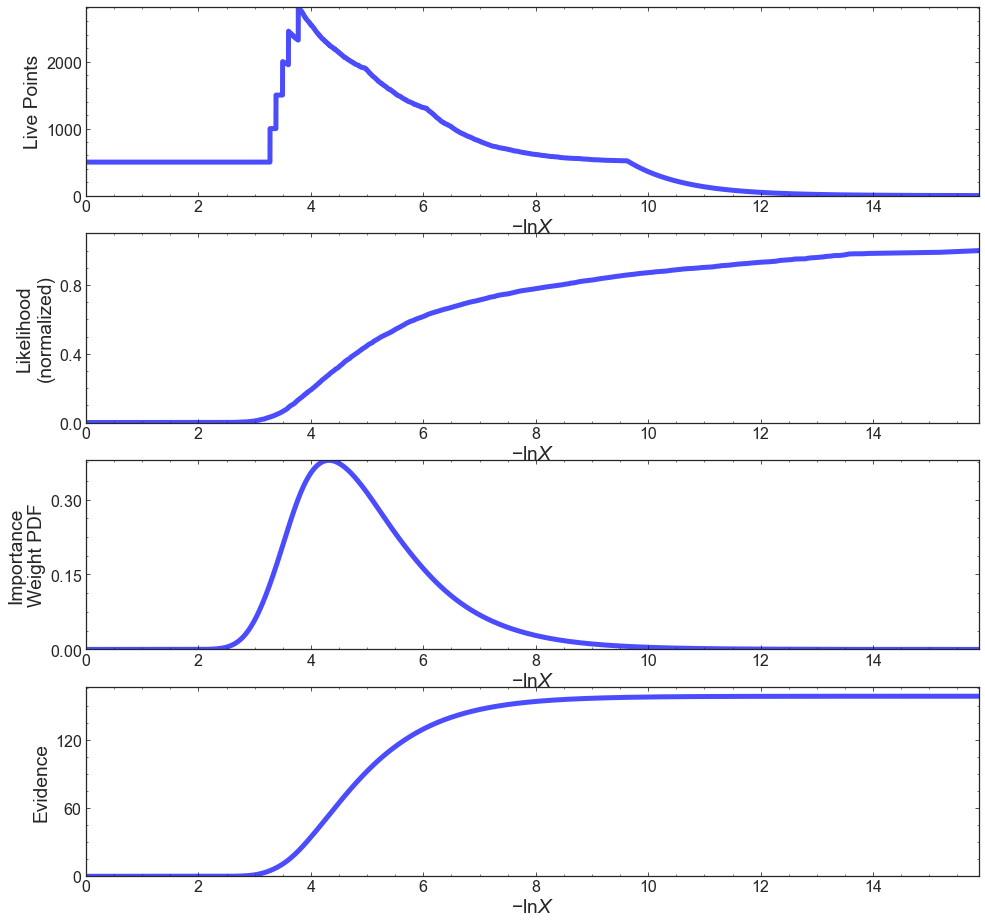

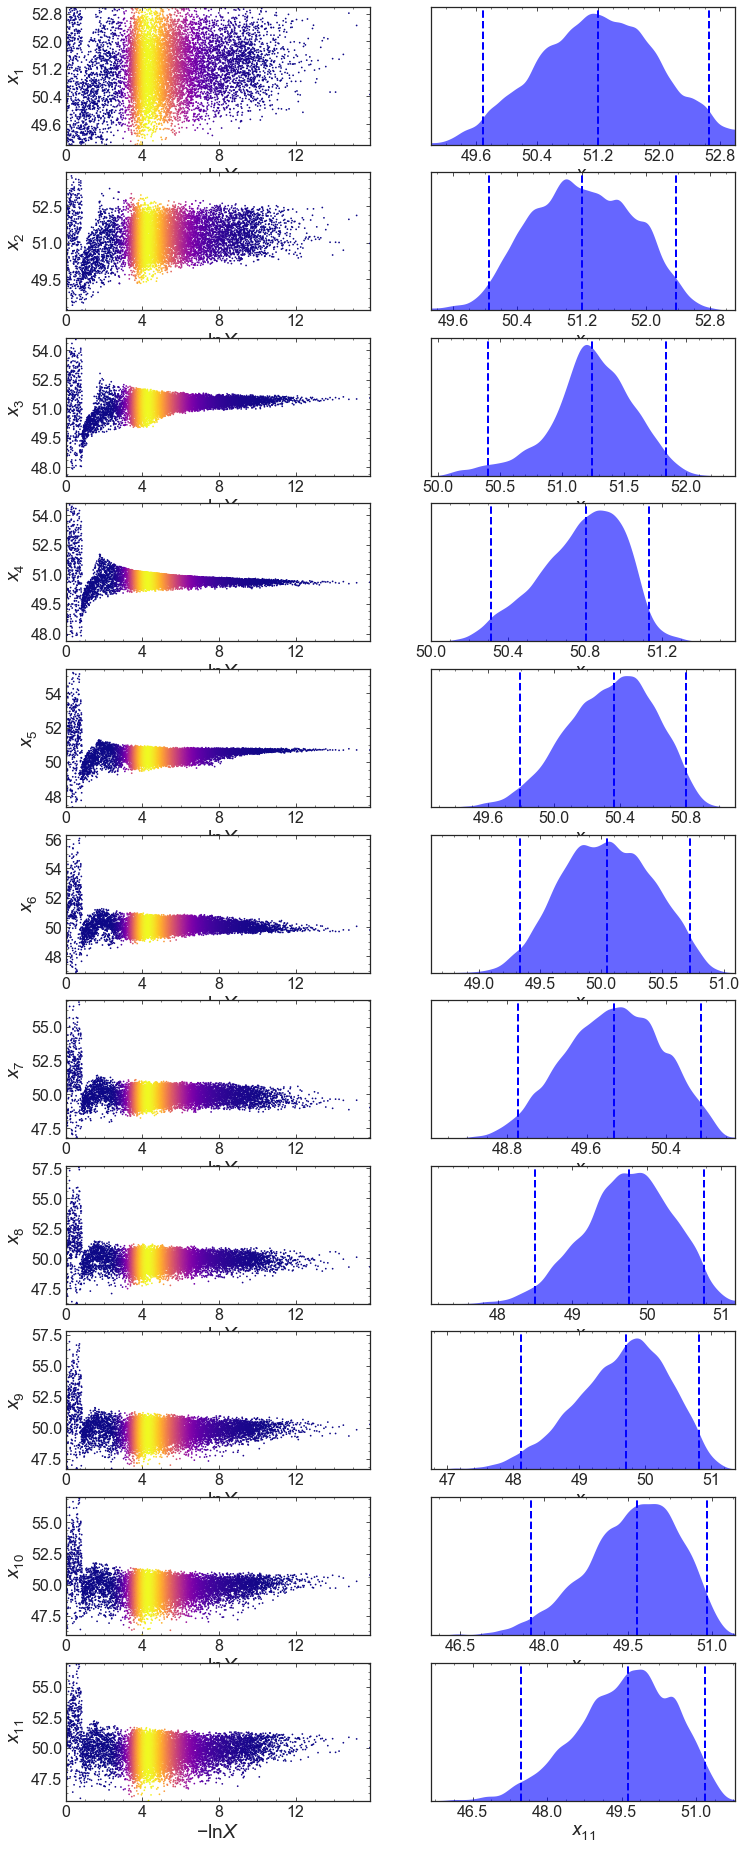

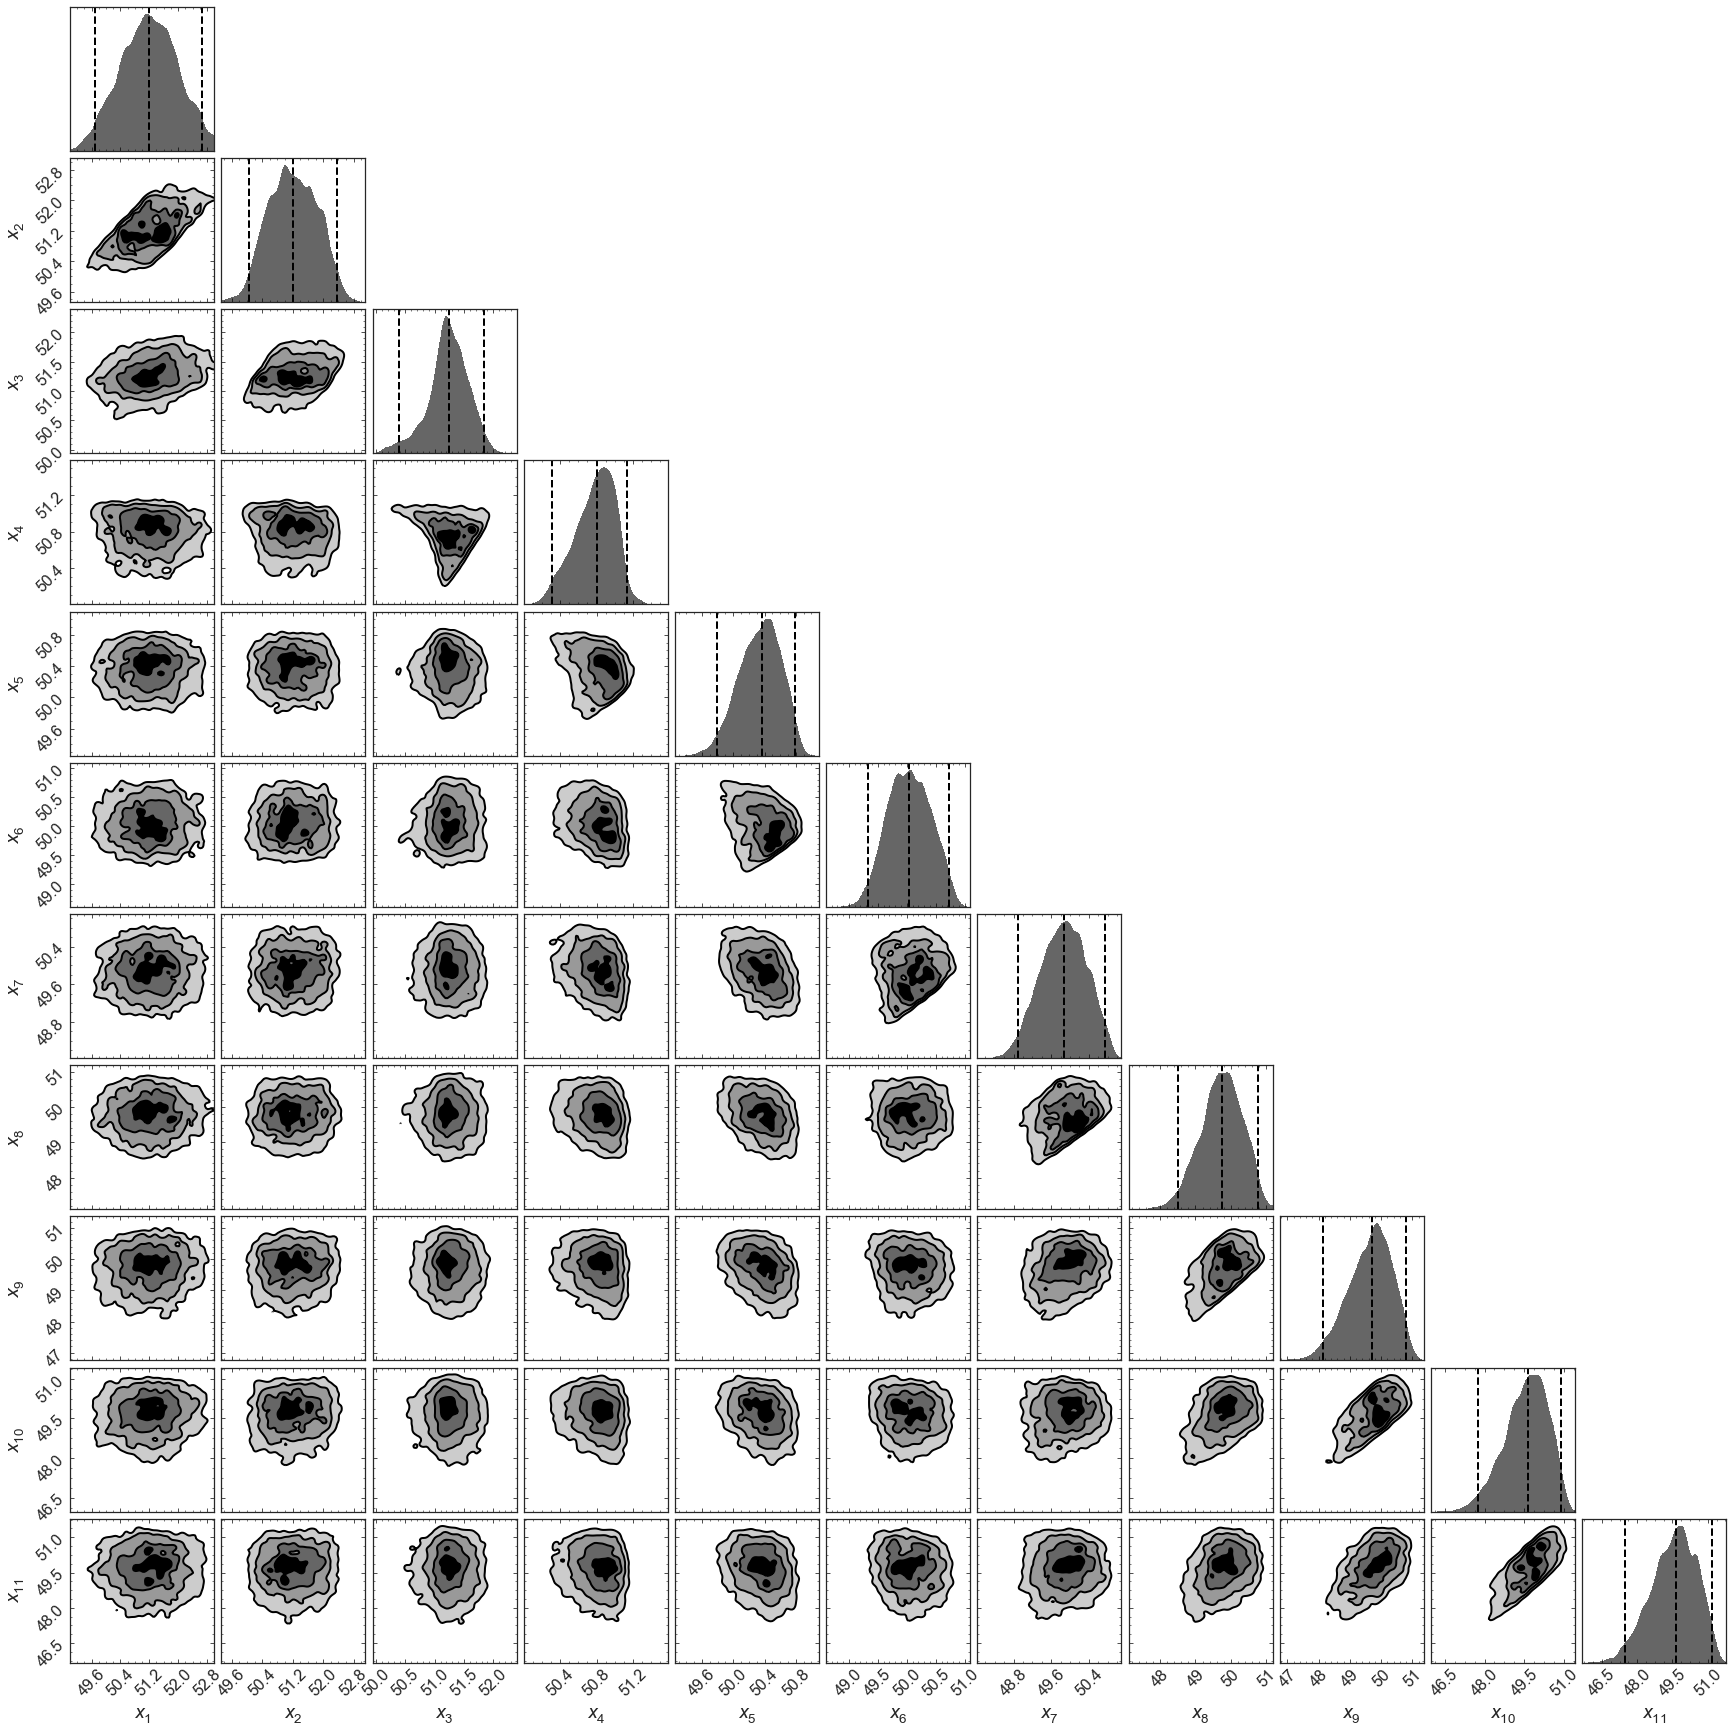

In [41]:
# Plot
dyn_plots(res_allobs_G19)

## Vary clumping factor

### Constant clumping factor

In [8]:
clump_factors = [1., 5., 10., 20., 30.]

maxiter = 5000
if __name__ == '__main__':

    for clump_fac in clump_factors:
        
        print(clump_fac)
        
        reion.C = clump_fac
        infer = reionization.NionInference(reion, ztab)
        
        # sample from the target distribution
        t0 = time.time()
        npool = 7
        with ProcessPoolExecutor(max_workers=npool) as executor:

            sampler = DynamicNestedSampler(
                                    infer.lnlike, infer.prior_transform, infer.ndim, 
                                    sample='rwalk', pool=executor, 
                                    queue_size=npool)

            sampler.run_nested(dlogz_init=0.1, nlive_init=500, maxiter=maxiter, use_stop=False, wt_kwargs={'pfrac': 1.0})

            res = sampler.results

            pickle.dump(res, open("chains/res_2obs_U[-1,1]_C=%.1f_49-53_pool.pickle" % clump_fac,"wb"))            

        t_run = (time.time()-t0)/60.
        print("Took {0:.10f} mins".format(t_run))
    
reion.C = 3.

iter: 1987 | batch: 0 | bound: 0 | nc: 73 | ncall: 19428 | eff(%):  9.971 | loglstar:   -inf <  8.706 <    inf | logz:  4.872 +/-  0.080 | dlogz:  0.718 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 2788 | batch: 0 | bound: 40 | nc: 394 | ncall: 99714 | eff(%):  2.782 | loglstar:   -inf <  8.880 <    inf | logz:  5.447 +/-  0.077 | dlogz:  0.112 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:224: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 5362 | batch: 3 | bound: 0 | nc: 24 | ncall: 150143 | eff(%):  3.571 | loglstar:  7.195 <  8.887 <  7.499 | logz:  5.566

Took 7.2437281370 mins


iter: 1880 | batch: 0 | bound: 0 | nc: 102 | ncall: 18371 | eff(%):  9.962 | loglstar:   -inf <  8.681 <    inf | logz:  5.146 +/-  0.076 | dlogz:  0.688 >  0.100            /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 1887 | batch: 0 | bound: 1 | nc: 43 | ncall: 18640 | eff(%):  9.859 | loglstar:   -inf <  8.688 <    inf | logz:  5.157 +/-  0.076 | dlogz:  0.675 >  0.100            /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number g

Took 9.1475507538 mins


iter: 1934 | batch: 0 | bound: 1 | nc: 42 | ncall: 19040 | eff(%):  9.898 | loglstar:   -inf <  8.685 <    inf | logz:  4.940 +/-  0.079 | dlogz:  0.737 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 1941 | batch: 0 | bound: 1 | nc: 62 | ncall: 19416 | eff(%):  9.746 | loglstar:   -inf <  8.696 <    inf | logz:  4.953 +/-  0.079 | dlogz:  0.724 >  0.100            /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 2490 | batch: 0 | bound: 18 | nc: 89 | ncall: 52330 | eff(%):  4.713 | loglstar:   -inf <  8.864 <    inf | logz:  

Took 9.0741220156 mins


iter: 1924 | batch: 0 | bound: 0 | nc: 37 | ncall: 18753 | eff(%):  9.993 | loglstar:   -inf <  8.683 <    inf | logz:  4.911 +/-  0.079 | dlogz:  0.763 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 1945 | batch: 0 | bound: 1 | nc: 26 | ncall: 19955 | eff(%):  9.509 | loglstar:   -inf <  8.705 <    inf | logz:  4.949 +/-  0.079 | dlogz:  0.721 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 2099 | batch: 0 | bound: 6 | nc: 35 | ncall: 27470 | eff(%):  7.504 | loglstar:   -inf <  8.787 <    inf | logz:  

Took 10.0883366108 mins


iter: 1877 | batch: 0 | bound: 1 | nc: 25 | ncall: 18626 | eff(%):  9.814 | loglstar:   -inf <  8.656 <    inf | logz:  4.924 +/-  0.079 | dlogz:  0.807 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 2246 | batch: 0 | bound: 11 | nc: 92 | ncall: 37903 | eff(%):  5.849 | loglstar:   -inf <  8.835 <    inf | logz:  5.374 +/-  0.077 | dlogz:  0.321 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:224: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 2518 | batch: 0 | bound: 24 | nc: 81 | ncall: 64672 | eff(%):  3.864 | loglstar:   -inf <  8.871 <    inf | logz:  5.517 

Took 11.7381161690 mins


### C(z) from Shull2012

In [8]:
# Inference object
reion.C = 'Shull2012'
infer = reionization.NionInference(reion, ztab)

maxiter = 5000
if __name__ == '__main__':
   
    # sample from the target distribution
    t0 = time.time()
    npool = 7
    with ProcessPoolExecutor(max_workers=npool) as executor:
        
        sampler = DynamicNestedSampler(
                                infer.lnlike, infer.prior_transform, infer.ndim, 
                                sample='rwalk', pool=executor, 
                                queue_size=npool)
        
        sampler.run_nested(dlogz_init=0.1, nlive_init=500, maxiter=maxiter, use_stop=False, wt_kwargs={'pfrac': 1.0})
        
        res = sampler.results
        
        pickle.dump(res, open("chains/res_2obs_C(z)=Shull2012_U[-1,1]_49-53_pool.pickle","wb"))

    t_run = (time.time()-t0)/60.
    print("Took {0:.10f} mins".format(t_run))
    
reion.C = 3.

iter: 1889 | batch: 0 | bound: 0 | nc: 48 | ncall: 18401 | eff(%):  9.994 | loglstar:   -inf <  8.672 <    inf | logz:  4.921 +/-  0.079 | dlogz:  0.796 >  0.100             /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:202: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 2736 | batch: 0 | bound: 42 | nc: 277 | ncall: 103418 | eff(%):  2.633 | loglstar:   -inf <  8.881 <    inf | logz:  5.569 +/-  0.075 | dlogz:  0.111 >  0.100            /home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/dynesty/sampling.py:224: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 3641 | batch: 1 | bound: 0 | nc: 7 | ncall: 125418 | eff(%):  2.699 | loglstar:  7.838 <  8.672 <  8.733 | logz:  5.679 

Took 13.3727745652 mins
